<a href="https://colab.research.google.com/github/LucasBorba1/project_hailmary/blob/main/project_hailmary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup and Class Definitions

In [6]:
# ================================
# CubeSat ADCS Simulator (Single File)
# ================================

import numpy as np
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt

# -------------------------------
# Reaction Wheel
# -------------------------------
class ReactionWheel:
    def __init__(self, axis, max_torque=0.01, inertia=1e-4):
        self.axis = np.array(axis) / np.linalg.norm(axis)
        self.max_torque = max_torque
        self.inertia = inertia
        self.omega = 0.0

    def apply_torque(self, torque_cmd, dt):
        torque = np.clip(torque_cmd, -self.max_torque, self.max_torque)
        self.omega += torque / self.inertia * dt
        return -torque * self.axis  # torque on CubeSat body

# -------------------------------
# CubeSat
# -------------------------------
class CubeSat:
    def __init__(self, mass=1.6, dimensions=(0.1,0.1,0.2), wheels=None):
        self.mass = mass
        self.dimensions = dimensions
        self.I = np.diag([0.5*mass*(dimensions[1]**2 + dimensions[2]**2),
                          0.5*mass*(dimensions[0]**2 + dimensions[2]**2),
                          0.5*mass*(dimensions[0]**2 + dimensions[1]**2)])
        self.I_inv = np.linalg.inv(self.I)

        self.omega = np.zeros(3)
        self.attitude = R.identity()
        self.wheels = wheels if wheels else []

        # history for plotting
        self.history = {'omega': [], 'attitude': []}

    def step(self, wheel_cmds, dt):
        total_torque = np.zeros(3)
        for wheel, cmd in zip(self.wheels, wheel_cmds):
            total_torque += wheel.apply_torque(cmd, dt)

        # Rigid body dynamics
        omega_dot = self.I_inv @ (total_torque - np.cross(self.omega, self.I @ self.omega))
        self.omega += omega_dot * dt

        # Integrate attitude
        rot_vec = self.omega * dt
        self.attitude = self.attitude * R.from_rotvec(rot_vec)

        # store history
        self.history['omega'].append(self.omega.copy())
        self.history['attitude'].append(self.attitude.as_quat().copy())

    def plot_omega(self):
        omega_hist = np.array(self.history['omega'])
        plt.figure(figsize=(6,4))
        plt.plot(omega_hist[:,0], label='wx')
        plt.plot(omega_hist[:,1], label='wy')
        plt.plot(omega_hist[:,2], label='wz')
        plt.legend()
        plt.xlabel('Step')
        plt.ylabel('Angular velocity [rad/s]')
        plt.title('CubeSat Body Angular Velocity')
        plt.show()

# -------------------------------
# Sensors
# -------------------------------
class Gyro:
    def __init__(self, noise_std=1e-4):
        self.noise_std = noise_std
    def read(self, omega_true):
        return omega_true + np.random.normal(0, self.noise_std, size=3)

class Accelerometer:
    def __init__(self, noise_std=1e-3):
        self.noise_std = noise_std
    def read(self, accel_true):
        return accel_true + np.random.normal(0, self.noise_std, size=3)

class Magnetometer:
    def __init__(self, noise_std=1e-5, magnetic_field=np.array([1.0,0.0,0.0])):
        self.noise_std = noise_std
        self.magnetic_field = np.array(magnetic_field)
    def read(self, attitude:R):
        mag_body = attitude.inv().apply(self.magnetic_field)
        return mag_body + np.random.normal(0, self.noise_std, size=3)

# -------------------------------
# Simple PID Controller
# -------------------------------
class PIDController:
    def __init__(self, Kp, Ki, Kd):
        self.Kp = Kp
        self.Ki = Ki
        self.Kd = Kd
        self.integral = np.zeros(3)
        self.prev_error = np.zeros(3)

    def step(self, error, dt):
        self.integral += error * dt
        derivative = (error - self.prev_error) / dt
        self.prev_error = error
        return self.Kp*error + self.Ki*self.integral + self.Kd*derivative

# -------------------------------
# Simulator
# -------------------------------
class Simulator:
    def __init__(self, cubesat, controller, sensors, dt=0.01):
        self.cubesat = cubesat
        self.controller = controller
        self.sensors = sensors
        self.dt = dt
        self.time = []

    def run(self, steps):
        for step in range(steps):
            # Read sensors
            gyro_reading = self.sensors['gyro'].read(self.cubesat.omega)
            accel_reading = self.sensors['accel'].read(np.zeros(3))
            mag_reading = self.sensors['mag'].read(self.cubesat.attitude)

            # Compute error (for demo, desired angular velocity = 0)
            error = -gyro_reading

            # Compute wheel torque commands
            wheel_cmds = self.controller.step(error, self.dt)

            # Step CubeSat dynamics
            self.cubesat.step(wheel_cmds, self.dt)
            self.time.append(step*self.dt)


# Build dataset

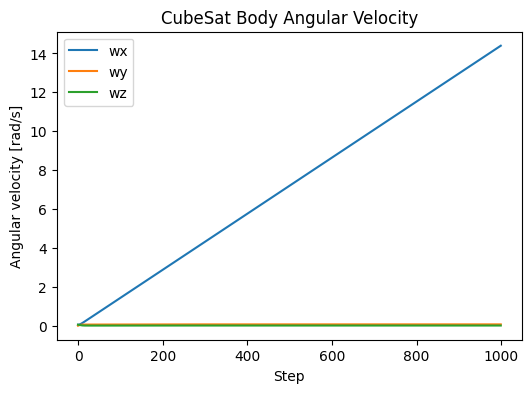

In [9]:
# -------------------------------
# Disturbance Test Routine
# -------------------------------

# Reset CubeSat state
sat.omega = np.zeros(3)
sat.attitude = R.identity()
sat.history = {'omega': [], 'attitude': []}

# Define a disturbance: e.g., an initial angular velocity or a torque pulse
disturbance_omega = np.array([0.05, -0.03, 0.02])  # rad/s initial spin
sat.omega += disturbance_omega

# PID controller
pid = PIDController(Kp=0.2, Ki=0.05, Kd=0.01)

# Simulator with sensors
sensors = {'gyro': Gyro(noise_std=1e-5),
           'accel': Accelerometer(noise_std=0.0),
           'mag': Magnetometer(noise_std=0.0)}

sim = Simulator(sat, pid, sensors, dt=0.05)

# Run simulation for 50 seconds (1000 steps)
sim.run(steps=1000)

# Plot results
sat.plot_omega()


# Animate


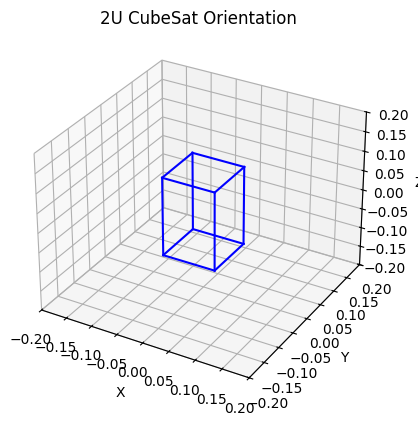

In [12]:
from IPython.display import HTML
import matplotlib as mpl
mpl.rcParams['animation.embed_limit'] = 100  # MB
from IPython.display import Video


def animate_cubesat(cubesat, interval=100):
    # Cube dimensions (2U)
    Lx, Ly, Lz = cubesat.dimensions
    vertices = np.array([[-Lx/2, -Ly/2, -Lz/2],
                         [ Lx/2, -Ly/2, -Lz/2],
                         [ Lx/2,  Ly/2, -Lz/2],
                         [-Lx/2,  Ly/2, -Lz/2],
                         [-Lx/2, -Ly/2,  Lz/2],
                         [ Lx/2, -Ly/2,  Lz/2],
                         [ Lx/2,  Ly/2,  Lz/2],
                         [-Lx/2,  Ly/2,  Lz/2]])
    edges = [(0,1),(1,2),(2,3),(3,0),
             (4,5),(5,6),(6,7),(7,4),
             (0,4),(1,5),(2,6),(3,7)]

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlim(-0.2,0.2)
    ax.set_ylim(-0.2,0.2)
    ax.set_zlim(-0.2,0.2)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('2U CubeSat Orientation')

    lines = [ax.plot([],[],[],color='b')[0] for _ in edges]

    def update(frame):
        quat = cubesat.history['attitude'][frame]
        rot = R.from_quat(quat)
        verts_rot = rot.apply(vertices)
        for i, (start,end) in enumerate(edges):
            lines[i].set_data([verts_rot[start,0], verts_rot[end,0]],
                              [verts_rot[start,1], verts_rot[end,1]])
            lines[i].set_3d_properties([verts_rot[start,2], verts_rot[end,2]])
        return lines

    anim = animation.FuncAnimation(fig, update, frames=len(cubesat.history['attitude']),
                                   interval=interval, blit=False)
    return anim  # return the animation to keep reference

# -------------------------------
# Run the animation in Colab
# -------------------------------
anim = animate_cubesat(sat, interval=100)
#HTML(anim.to_jshtml())
anim.save("cubesat.mp4", writer='ffmpeg', fps=10)
Video("cubesat.mp4")


# Generate dataset


In [13]:
import pandas as pd

# Build dataset
data = []
for i in range(len(sat.history['omega'])):
    omega = sat.history['omega'][i]
    quat = sat.history['attitude'][i]
    # If you want, also include wheel states or sensor readings
    row = {
        'step': i,
        'wx': omega[0],
        'wy': omega[1],
        'wz': omega[2],
        'qx': quat[0],
        'qy': quat[1],
        'qz': quat[2],
        'qw': quat[3],
    }
    data.append(row)

df = pd.DataFrame(data)
df.to_csv('cubesat_sim_data.csv', index=False)
